# Toy Models of Superposition revisited

**Introduction:**

This file contains an adaptation of the first cells of the colab notebook [toy_models.ipynb](https://colab.research.google.com/github/anthropics/toy-models-of-superposition/blob/main/toy_models.ipynb), from Anthropic's paper ["Toy models of superposition"](https://transformer-circuits.pub/2022/toy_model/index.html).

**Authors:**

The paper was authored by Nelson Elhage, Tristan Hume, Catherine Olsson, Nicholas Schiefer, Tom Henighan, Shauna Kravec, Zac Hatfield-Dodds, Robert Lasenby, Dawn Drain, Carol Chen, Roger Grosse, Sam McCandlish, Jared Kaplan, Dario Amodei, Martin Wattenberg and Christopher Olah, who are to be credited for the original code and the ideas presented.

**This notebook:**

The goal of this adaptation is to show the behavior of the simple autoencoder proposed by Elhage et al. when compressing samples that comprise a number of features under different correlation regimes and zero sparsity.

**The pipeline:**

We train the autoencoder proposed by Elhage et al., where the latent representation is a linear compression to two dimensions of the inputs $x$ to a lower dimension $h = Wx$. The decoder then decompresses the input via a ReLU activation $x’ = \text{ReLU}(W^{T} h + b) = \text{ReLU}(W^{T}Wx + b)$.

 Our dataset is multivariate gaussian where $N_{features}= 5$ are different components of a multivariate gaussian with mean vector zero and unit variance, i.e. $x \sim N(0,1)$. The covariance between features is controlled via a hyperparameter α, which describes its sparsity. The loss function is the mean squared error between inputs and outputs, since we assigned all features equal importance, i.e. $L = \Sigma_{x} \Sigma_{i} (x_i-x_i’)^2 $.

 _Note:_

 _Each column in the weight matrix $W$ corresponds to a direction in the latent space (2D) representing each feature $x_i$, which we will plot._

**Main conclusions:**
- Independent features cannot be compressed. The model must prioritize, learn as many as the latent dimension allows and ignore the rest.
- When compressing correlated features, the model can represent more features than latent dimensions.


In [1]:
!pip install einops

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [3]:
@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We could potentially use torch.vmap instead.
  n_instances: int

class Model(nn.Module):
  def __init__(self,
               config,
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

> Custom model where we generate batches of samples as a multivariate gaussian where we control the degree of correlations between variables via the $\alpha$ parameter of the covariance matrix.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Optional

@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int

class Model(nn.Module):
    def __init__(self,
                 config,
                 feature_probability: Optional[torch.Tensor] = None,
                 importance: Optional[torch.Tensor] = None,
                 device='cuda',
                 alpha: float = 0.5):
        super().__init__()
        self.config = config
        self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

        # Parameters for multivariate Gaussian
        self.mean = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        # Initialize covariance matrix with correlations
        self.base_corr = self.initialize_base_correlation(config.n_features, device)
        self.var = nn.Parameter(torch.ones(config.n_instances, config.n_features, device=device))
        self.alpha = alpha
        self.update_covariance()

    def initialize_base_correlation(self, n_features, device):
        # Create a base correlation matrix
        base_corr = torch.eye(n_features, device=device)

        # Add some off-diagonal correlations
        for i in range(n_features):
            for j in range(i+1, n_features):
                corr_value = torch.rand(1, device=device)  # Random correlation between 0 and 1
                base_corr[i, j] = corr_value
                base_corr[j, i] = corr_value

        return base_corr

    def update_covariance(self):
        # Apply alpha to off-diagonal elements
        corr = torch.eye(self.config.n_features, device=self.W.device) + self.alpha * (self.base_corr - torch.eye(self.config.n_features, device=self.W.device))

        # Ensure the matrix is positive definite
        corr = corr @ corr.T + torch.eye(self.config.n_features, device=self.W.device) * 0.01

        # Create covariance matrix
        self.cov_matrix = corr.unsqueeze(0) * self.var.unsqueeze(-1) * self.var.unsqueeze(-2)

    def set_alpha(self, new_alpha: float):
        """
        Set a new alpha value and update the covariance matrix.
        """
        self.alpha = new_alpha
        self.update_covariance()

    def forward(self, features):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        out = F.relu(out)
        return out

    def generate_batch(self, n_batch):
        # Generate samples from multivariate Gaussian
        dist = torch.distributions.MultivariateNormal(self.mean, covariance_matrix=self.cov_matrix)
        batch = dist.sample((n_batch,))

        # We remove the probability mask: we want 0 sparsity
        #mask = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability
        #batch = torch.where(mask, batch, torch.zeros_like(batch))

        return batch

In [5]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()

      if hooks:
        hook_data = dict(model=model,
                         step=step,
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )


In [30]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

## Introduction Figure

This figure is a variant of the one presented in the introduction of Elhage et al.. In this case we modulated the degree of correlation between input features instead of their sparsity.

In [31]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 4,
)

model = Model(
    config=config,
    device=DEVICE,
     importance = (torch.ones(config.n_features))[None, :], # Equal importance
    feature_probability = (torch.zeros( config.n_instances))[:, None], # The mask is not used anyway
    alpha = 0.0
)

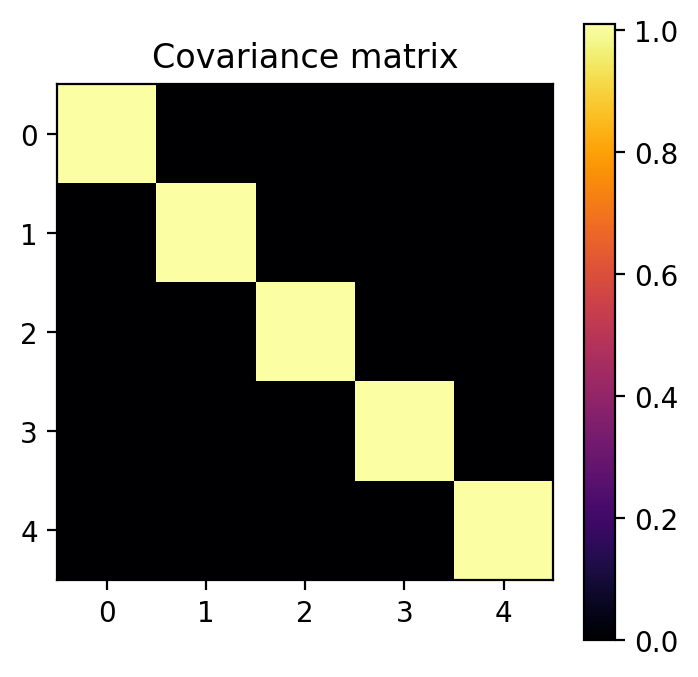

In [36]:
# Plot covariance matrix
plt.figure(figsize=(4,4))
plt.title("Covariance matrix")
plt.imshow(model.cov_matrix.detach().cpu().numpy()[i], cmap='inferno')
plt.colorbar()
plt.show()

In [33]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

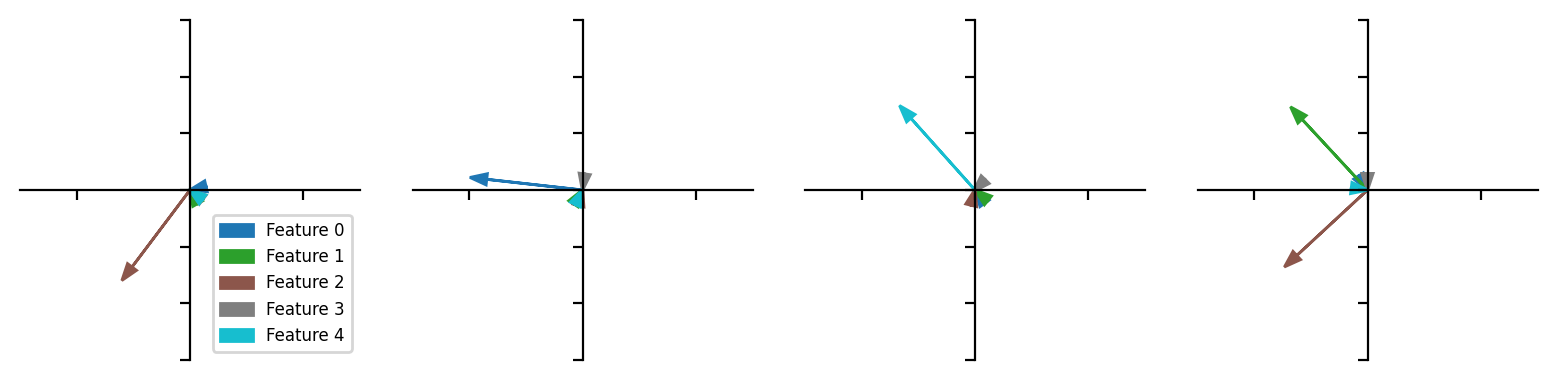

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
from matplotlib import collections as mc

def plot_intro_diagram(model):
    cfg = model.config
    WA = model.W.detach()
    N = len(WA[:,0])
    sel = range(cfg.n_instances)  # can be used to highlight specific sparsity levels

    # Create a colormap instance
    cmap = plt.cm.tab10

    plt.rcParams['figure.dpi'] = 200
    fig, axs = plt.subplots(1, len(sel), figsize=(2*len(sel), 2))

    if len(sel) == 1:
        axs = [axs]  # Ensure axs is always a list for consistent indexing

    for i, ax in zip(sel, axs):
        W = WA[i].cpu().detach().numpy()

        # Generate colors from the inferno colormap
        colors = [cmap(j / (cfg.n_features - 1)) for j in range(cfg.n_features)]

        for j in range(cfg.n_features):
            ax.arrow(0, 0, W[j,0], W[j,1], length_includes_head=True,
                     head_width=0.1, label=f"Feature {j}", color=colors[j])

        ax.set_aspect('equal')

        if i == 0:
          ax.legend(fontsize=6, loc="lower right")


        z = 1.5
        ax.set_xlim((-z, z))
        ax.set_ylim((-z, z))
        ax.tick_params(left=True, right=False, labelleft=False,
                       labelbottom=False, bottom=True)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        for spine in ['bottom', 'left']:
            ax.spines[spine].set_position('center')

    plt.tight_layout()
    plt.show()

# Usage
plot_intro_diagram(model)